In [ ]:
#This is ppo implementation with our custom env and the same with reinforce in terms of reward function:

Part 0: Input Dataset

In [7]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==== Load Animal Dataset ====
import pandas as pd

df = pd.read_excel('knowledge_base1.xlsx')
FEATURES = ["Hair", "Feathers", "Eggs", "Milk", "Airborne", "Aquatic", "Predator", "Toothed",
            "Backbone", "Breathes", "Venomous", "Fins", "Nlegs_0", "Nlegs_2", "Nlegs_4",
            "Nlegs_5", "Nlegs_6", "Nlegs_8", "Tail", "Domestic", "Catsize",
            "Mammal", "Bird", "Reptile", "Fish", "Amphibian", "Insect", "Invertebrate"]

animal_features = df.iloc[:, 1:].values  # Exclude animal name column

print('finish')

finish


Part 1: Game Logic (TwentyQGame)

In [4]:
import numpy as np
import random

class Animal20QEnv:
    def __init__(self, animal_features, max_steps=20):
        self.animal_features = animal_features  # Full dataset of animal-feature matrix
        self.num_animals = len(animal_features)
        self.num_features = animal_features.shape[1]
        self.max_steps = max_steps

    def reset(self):
        self.target_idx = random.randint(0, self.num_animals - 1)
        self.remaining_animals = list(range(self.num_animals))  # Start with all animals
        self.asked_features = set()
        self.steps = 0
        self.state = np.zeros(self.num_features, dtype=np.float32)  # Initial state: unanswered
        return self.state

    def step(self, feature_idx):
        previous_remaining = len(self.remaining_animals)

        # Get the target animal's answer for the feature
        answer = self.animal_features[self.target_idx][feature_idx]

        # Filter remaining animals by matching the answer
        new_remaining = [
            idx for idx in self.remaining_animals
            if self.animal_features[idx][feature_idx] == answer
        ]
        self.remaining_animals = new_remaining

        # Update state vector
        self.state[feature_idx] = answer
        self.steps += 1
        done = self.steps >= self.max_steps

        # --- Reward calculation ---
        eliminated = previous_remaining - len(self.remaining_animals)
        reward = eliminated

        if eliminated >= 10:
            reward += 10  # Bonus for strong elimination

        if feature_idx in self.asked_features:
            reward -= 5  # Penalty for repetition
        else:
            self.asked_features.add(feature_idx)

        # Final step: make a guess
        if done:
            guessed_idx = self.guess_animal()
            if guessed_idx == self.target_idx:
                reward += 50  # Correct guess
            else:
                reward -= 10  # Incorrect guess

        return self.state.copy(), reward, done

    def guess_animal(self):
        """Make a guess based on current state using cosine similarity."""
        if np.all(self.state == 0):
            return random.choice(self.remaining_animals)  # No info yet, random guess
        match_scores = self.animal_features @ self.state
        return np.argmax(match_scores)


Part 2: PPO Agent

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU())
        self.actor = nn.Linear(128, action_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        shared = self.shared(x)
        return self.actor(shared), self.critic(shared)

class PPO:
    def __init__(self, state_dim, action_dim):
        self.model = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.gamma = 0.99
        self.eps_clip = 0.2

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        logits, _ = self.model(state)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def train_step(self, states, actions, rewards, log_probs, next_states, dones):
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        log_probs = torch.stack(log_probs)
        dones = torch.tensor(dones, dtype=torch.float32)

        _, next_values = self.model(torch.tensor(next_states, dtype=torch.float32))
        _, values = self.model(states)
        values = values.squeeze()
        next_values = next_values.squeeze()

        returns = rewards + self.gamma * next_values * (1 - dones)
        advantages = returns - values

        new_logits, _ = self.model(states)
        new_probs = torch.softmax(new_logits, dim=-1)
        new_dist = torch.distributions.Categorical(new_probs)
        new_log_probs = new_dist.log_prob(actions)

        ratio = torch.exp(new_log_probs - log_probs.detach())
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
        loss = -torch.min(surr1, surr2).mean() + (returns - values).pow(2).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


Part 3: Training Loop with Success Rate and Question Log

/tmp/ipykernel_2732494/1150451683.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.tensor(states, dtype=torch.float32)


Episode 50, Average Success Rate: 0.30
Episode 100, Average Success Rate: 0.22
Episode 150, Average Success Rate: 0.24
Episode 200, Average Success Rate: 0.20
Episode 250, Average Success Rate: 0.24
Episode 300, Average Success Rate: 0.26
Episode 350, Average Success Rate: 0.28
Episode 400, Average Success Rate: 0.16
Episode 450, Average Success Rate: 0.04
Episode 500, Average Success Rate: 0.16
Episode 550, Average Success Rate: 0.12
Episode 600, Average Success Rate: 0.14
Episode 650, Average Success Rate: 0.14
Episode 700, Average Success Rate: 0.12
Episode 750, Average Success Rate: 0.18
Episode 800, Average Success Rate: 0.14
Episode 850, Average Success Rate: 0.18
Episode 900, Average Success Rate: 0.14
Episode 950, Average Success Rate: 0.12
Episode 1000, Average Success Rate: 0.16


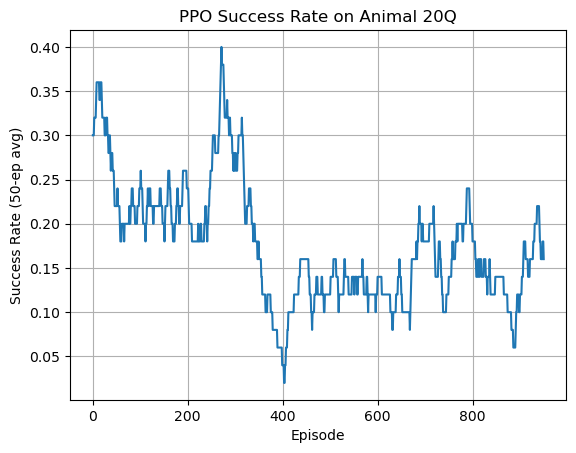

In [8]:
env = Animal20QEnv(animal_features=animal_features)
ppo = PPO(state_dim=NUM_FEATURES, action_dim=NUM_FEATURES)

episodes = 1000
success_log = []

for ep in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    log_probs = []
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []

    while not done:
        action, log_prob = ppo.select_action(state)
        next_state, reward, done = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        dones.append(done)
        log_probs.append(log_prob)

        state = next_state
        total_reward += reward

    ppo.train_step(states, actions, rewards, log_probs, next_states, dones)
    success = int(env.guess_animal() == env.target_idx)
    success_log.append(success)

    if (ep + 1) % 50 == 0:
        avg_success = np.mean(success_log[-50:])
        print(f"Episode {ep + 1}, Average Success Rate: {avg_success:.2f}")

# ==== Plot Success Rate ====
plt.plot(np.convolve(success_log, np.ones(50)/50, mode='valid'))
plt.xlabel("Episode")
plt.ylabel("Success Rate (50-ep avg)")
plt.title("PPO Success Rate on Animal 20Q")
plt.grid(True)
plt.show()